In [5]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2 as cv
from torch.utils.tensorboard import SummaryWriter

In [6]:
print(torch.backends.mps.is_available())

True


In [7]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(), writer = None, epoch = None, device = None):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for batch_idx, (features,labels) in enumerate(dataloader):
        optimizer.zero_grad()
        features = features.to(device)
        labels = labels.to(device)
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
        img_grid = torchvision.utils.make_grid(features)
        writer.add_image("mnist images", img_grid, batch_idx)
        writer.add_histogram('fc', ConvNN.fc3.weight, batch_idx)
            
        if batch_idx%100 == 0:
            print('Train Epoch: {} [{:>5d}/{:>5d} ({:.0f}%)] \t\tLoss: {:.6f}'.format(
                epoch + 1,
                batch_idx*len(features),
                len(dataloader.dataset),
                100. * batch_idx / len(dataloader),
                loss.item()
            ))
            writer.add_scalar("Train Accuracy", acc.item()/count, epoch*60000+count)
            writer.add_scalar("Train Loss", total_loss.item()/count, epoch*6000 + count)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader, loss_fn=nn.NLLLoss(), device = None):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            features = features.to(device)
            labels = labels.to(device)
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss(), writer = None, device = None):
    #optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        lr = L_rate(ep, lr)
        writer.add_scalar("Learning Rate", lr, ep)
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn, epoch = ep, writer = writer, device = device)
        vl,va = validate(net,test_loader,loss_fn=loss_fn, device = device)
        print(f"-----------------------------------------\nEpoch {ep+1:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}\n")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.ylim(0, 1)
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.legend()
    
def img_to_torch(img):
    rows, cols = 28, 28
    img = cv.resize(img, (rows, cols), interpolation = cv.INTER_LINEAR)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    for row in range(rows):
        for col in range(cols):
            img[row, col] = (255 - img[row, col])
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.type(torch.FloatTensor)/255
    img = (img - 0.5)/0.5
    #img = img.permute(0, 1, 2)
    return img

def load_mnist(batch_size = 32):
    transform1 = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, ), (0.5, ))])
    train_data = torchvision.datasets.MNIST(
        root = './data',
        download = True,
        train = True,
        transform = transform1
    )
    test_data = torchvision.datasets.MNIST(
        root = './data',
        download = True,
        train = False,
        transform = transform1
    )
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
    
    return train_data, test_data, train_loader, test_loader

def L_rate(ep, lr):
    if ep<5:
        lr = lr
    elif ep>5 and ep<8:
        lr = lr/10
    elif ep>8:
        lr = lr/50
    return lr

In [8]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=20, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=180, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        return x
    
ConvNN = AlexNet(10).to(device)

In [4]:
summary(ConvNN, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 28, 28]           260
├─Conv2d: 1-2                            [1, 16, 14, 14]           4,016
├─Conv2d: 1-3                            [1, 32, 7, 7]             4,640
├─Conv2d: 1-4                            [1, 20, 7, 7]             5,780
├─Conv2d: 1-5                            [1, 20, 7, 7]             3,620
├─Linear: 1-6                            [1, 1024]                 185,344
├─Linear: 1-7                            [1, 512]                  524,800
├─Linear: 1-8                            [1, 10]                   5,130
Total params: 733,590
Trainable params: 733,590
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.39
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 2.93
Estimated Total Size (MB): 3.07

Train Epoch: 1 [    0/60000 (0%)] 		Loss: 2.303053
Train Epoch: 1 [ 3200/60000 (5%)] 		Loss: 0.820536
Train Epoch: 1 [ 6400/60000 (11%)] 		Loss: 0.228317
Train Epoch: 1 [ 9600/60000 (16%)] 		Loss: 0.315128
Train Epoch: 1 [12800/60000 (21%)] 		Loss: 0.057401
Train Epoch: 1 [16000/60000 (27%)] 		Loss: 0.225387
Train Epoch: 1 [19200/60000 (32%)] 		Loss: 0.139060
Train Epoch: 1 [22400/60000 (37%)] 		Loss: 0.051587
Train Epoch: 1 [25600/60000 (43%)] 		Loss: 0.108036
Train Epoch: 1 [28800/60000 (48%)] 		Loss: 0.197359
Train Epoch: 1 [32000/60000 (53%)] 		Loss: 0.095027
Train Epoch: 1 [35200/60000 (59%)] 		Loss: 0.022217
Train Epoch: 1 [38400/60000 (64%)] 		Loss: 0.099712
Train Epoch: 1 [41600/60000 (69%)] 		Loss: 0.630740
Train Epoch: 1 [44800/60000 (75%)] 		Loss: 0.056876
Train Epoch: 1 [48000/60000 (80%)] 		Loss: 0.430250
Train Epoch: 1 [51200/60000 (85%)] 		Loss: 0.105352
Train Epoch: 1 [54400/60000 (91%)] 		Loss: 0.028451
Train Epoch: 1 [57600/60000 (96%)] 		Loss: 0.072934
--------------

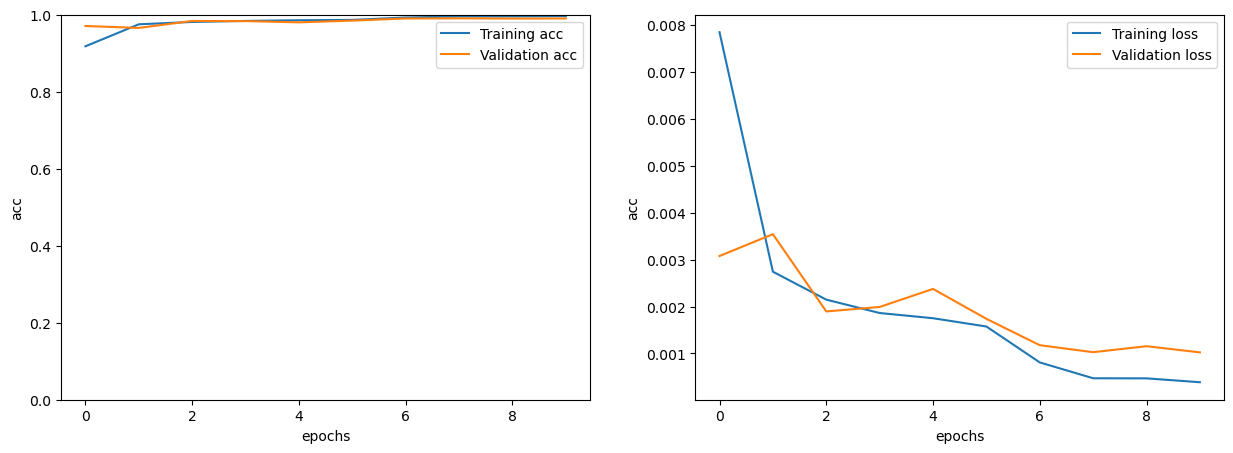

In [9]:
train_data, test_data, train_loader, test_loader= load_mnist()
learning_rate = 1e-3
log_dir = "./AlexNetMnist/"
writer = SummaryWriter(log_dir)

hist = train(ConvNN, train_loader, test_loader, lr=1e-3, epochs=10, loss_fn=nn.CrossEntropyLoss(), writer = writer, device = device)
plot_results(hist)
writer.close()

In [26]:
def img_torch(img):
    rows, cols = 28, 28
    img = cv.resize(img, (rows, cols), interpolation = cv.INTER_LINEAR)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    for row in range(rows):
        for col in range(cols):
            img[row, col] = (255 - img[row, col])
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.type(torch.FloatTensor)/255
    img = img.unsqueeze(0)
    img = (img - 0.5)/0.5
    #img = img.permute(0, 1, 2)
    return img

In [102]:
ConvNN.train()
optimizer = torch.optim.Adam(ConvNN.parameters(),lr=1e-3)
img = cv.imread(f"/Users/jayson/Documents/VSCODE/pytorch/data/handwrite/five11.jpg")
features = img_torch(img)
labels = torch.tensor([4])
optimizer.zero_grad()
out = ConvNN(features)
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(out,labels)
loss.backward()
optimizer.step()

In [27]:
torch.save(ConvNN.state_dict(), "data/AlexNet.pth")
print("Saved PyTorch Model State to AlexNet.pth")

Saved PyTorch Model State to AlexNet.pth


In [8]:
ConvNN.load_state_dict(torch.load("/Users/jayson/Documents/VSCODE/pytorch/MNIST_EX/data/AlexNet.pth"))

/var/folders/6q/k5hs6tzd647_yk5x07bqfxxc0000gp/T/ipykernel_98924/2223564054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ConvNN.load_state_dict(torch.load("/Users/jay

<All keys matched successfully>

In [9]:
handwrite_list = [[]]
number = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
for i in range(0, 10):
    numb = number[i]
    for j in range(0, 21):
        img = cv.imread(f"/Users/jayson/Documents/VSCODE/pytorch/data/handwrite/{numb}{j}.jpg")
        img = img_to_torch(img)
        handwrite_list.append([img, i])
del handwrite_list[0]

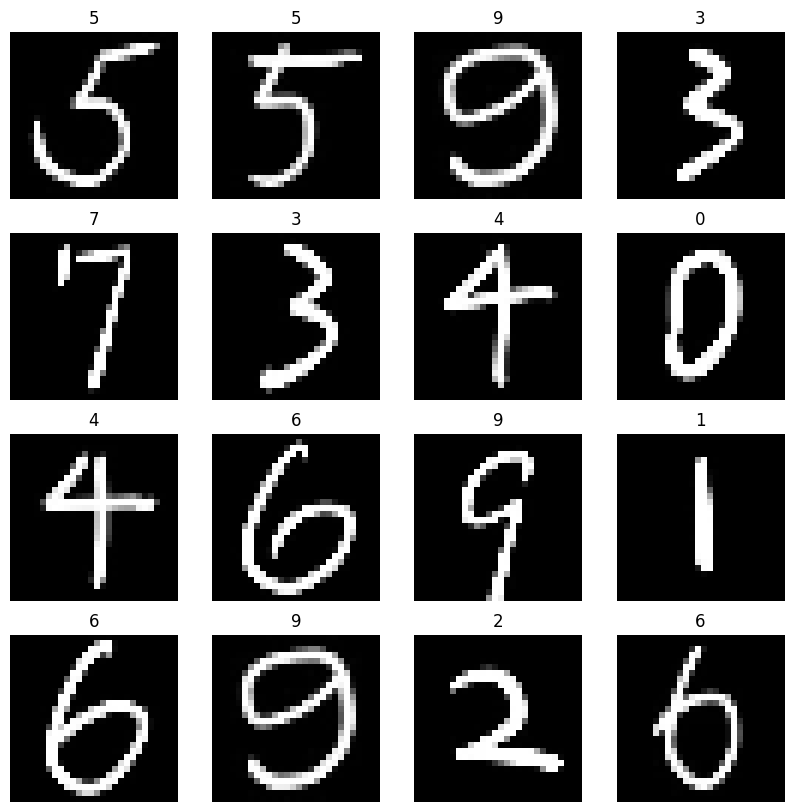

In [10]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(handwrite_list), size=(1,)).item()
    img, label = handwrite_list[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [18]:
data_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 1)
ConvNN.eval().cpu()
i, j = 0, 0
for x, y in data_loader:
    with torch.no_grad():
        pred = ConvNN(x)
        predicted, actual = pred[0].argmax(0), y.item()
        if predicted == actual:
            j += 1
hand_acc = j/len(test_data)*100
print(f"Accuracy: {hand_acc:.2f}%")

Accuracy: 97.56%


ValueError: num must be an integer with 1 <= num <= 212, not 213

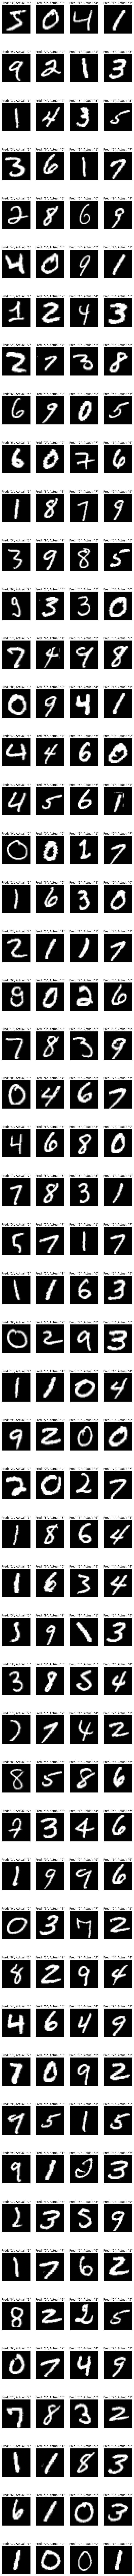

In [15]:
data_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 1)
ConvNN.eval().cpu()
figure1 = plt.figure(figsize=(10, 200))
i, j = 0, 0
for x, y in data_loader:
    figure1.add_subplot(53, 4, i+1)
    i += 1
    with torch.no_grad():
        pred = ConvNN(x)
        predicted, actual = pred[0].argmax(0), y.item()
        #print(f'Pred: "{predicted}", Actual: "{actual}"')
        plt.title(f'Pred: "{predicted}", Actual: "{actual}"')
        plt.axis("off")
        plt.imshow(x.squeeze(), cmap = "gray")
        if predicted == actual:
            j += 1
hand_acc = j/len(handwrite_list)*100
print(f"Accuracy: {hand_acc:.2f}%")
plt.show()